In [44]:
import pandas as pd
import numpy as np

In [45]:
data_product_sales = pd.read_csv("product_sales.csv", sep="\t")

data_travelers = pd.read_csv("travelers.csv", sep="\t")

data_trips = pd.read_csv("trips.csv", sep="\t")

In [46]:
len(set(data_trips["reservation_id"])) #means that reservation ids are not duplicated

20000

In [47]:
tmp_sheet = pd.concat([data_trips.set_index('traveler_id'),data_travelers.set_index('id')], axis=1, join='inner')

In [48]:
tmp_sheet["traveler_id"] = tmp_sheet.index

In [49]:
X_raw = tmp_sheet.reset_index(drop=True)

In [50]:
list(X_raw)

['reservation_id',
 'reservation_date',
 'package_type',
 'departure_date',
 'departure_code',
 'arrival_code',
 'arrival_country',
 'return_date',
 'carrier_id',
 'no_of_adults',
 'no_of_kids',
 'birthdate',
 'gender_id',
 'country_id',
 'traveler_id']

In [51]:
features = [
     'reservation_date',
     'package_type',
     'departure_date',
     'departure_code',
     'arrival_code',
     'arrival_country',
     'return_date',
     'carrier_id',
     'no_of_adults',
     'no_of_kids',
     'birthdate',
     'gender_id',
     'country_id',
]

In [52]:
X = X_raw[features]

In [53]:
# merge product_sales with X_raw, where the samples which did not buy the reservation are set as NaN
tmp_sheet_1 = pd.concat([X_raw.set_index('reservation_id'), data_product_sales.set_index('reservation_id')], axis=1, sort=False) 

In [54]:
tmp_sheet_1["reservation_id"] = tmp_sheet_1.index

In [55]:
tmp_sheet_1 = tmp_sheet_1.reset_index(drop=True)

In [56]:
# merge product_sales with X_raw, where the samples which did not buy the reservation are set as NaN

tmp_sheet_2 = pd.merge(X_raw, data_product_sales, on='reservation_id', how='outer') 

In [57]:
tmp_sheet_1 = tmp_sheet_1.reindex(sorted(tmp_sheet_1.columns), axis=1)

In [58]:
tmp_sheet_2 = tmp_sheet_2.reindex(sorted(tmp_sheet_2.columns), axis=1)

In [59]:
tmp_sheet_1.sort_values(by='reservation_id').equals(tmp_sheet_2.sort_values(by='reservation_id'))

True

In [60]:
# create a dataframe for testing

df1 = pd.DataFrame(
{
    'c1': [1,2],
    'c2': [2,3]
}
)

In [61]:
tmp_sheet_1 = tmp_sheet_1.fillna(value=0)

In [62]:
X_raw = tmp_sheet_1

In [63]:
y = X_raw["bought_product"]

In [64]:
X = X_raw

In [65]:
# create a feature called 'duration'

pd.options.mode.chained_assignment = None  # default='warn'

X['departure_date'] = pd.to_datetime(X['departure_date'])

X['return_date'] = pd.to_datetime(X['return_date'])

X['duration'] = (X['return_date'] - X['departure_date']).dt.days

In [66]:
# create another feature called 'age'
import datetime 

In [67]:
X['age'] = ((pd.Timestamp('2019-01-01 00:00:00') - pd.to_datetime(X["birthdate"]))/365.0).dt.days
X['departure_month'] = pd.to_datetime(X_raw['departure_date']).dt.month
X['return_month'] = pd.to_datetime(X_raw['return_date']).dt.month

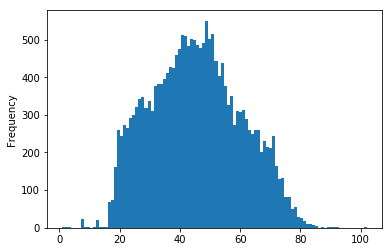

In [68]:
X['age'].plot.hist(bins=100)

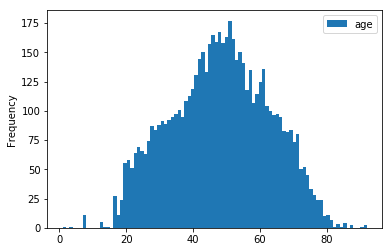

In [69]:
X.loc[X['bought_product']==1,['age']].plot.hist(bins=90)

In [70]:
len(X.loc[(X['age']==2) & (X['bought_product']==1)])

0

In [71]:
features = list(X)

In [72]:
label_features = [
    'package_type',
    'departure_code',
    'arrival_code',
    'arrival_country',
    'carrier_id',
    'gender_id',
    'country_id',
    'departure_month',
    'return_month',
    'no_of_adults',
    'no_of_kids',
    'age',
    'duration',
]

In [73]:
numerical_features = [

]

In [74]:
selected_features = label_features + numerical_features

In [75]:
X = X[selected_features]

In [76]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler = scaler.fit(X[numerical_features])
# X[numerical_features] = scaler.transform(X[numerical_features])

In [77]:
# label encoding 
from sklearn import preprocessing 

le = preprocessing.LabelEncoder()

for name in label_features:
    le = preprocessing.LabelEncoder()
    le = le.fit(X[name])
    X[name] = le.transform(X[name])

In [78]:
# # dummy encoding
# for category_name in label_features:
#     X[category_name] = X[category_name].astype('category')

# dummy_columns = pd.get_dummies(X[label_features])

# X = X.drop(label_features, axis=1) # axis=1 means that columns are dropped instead of samples

# X = pd.concat([X,dummy_columns], axis = 1) 

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
# test_features = selected_features
# X = X[test_features]

In [81]:
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size = 0.2)

In [82]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators = 100)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_new)

from sklearn.metrics import accuracy_score

accuracy_score(y_new, y_pred)

0.69225

In [83]:
pd.DataFrame({
    'feature': list(X_new),
    'importance': clf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
11,age,0.41
2,arrival_code,0.12
3,arrival_country,0.10
1,departure_code,0.09
8,return_month,0.05
12,duration,0.05
9,no_of_adults,0.04
10,no_of_kids,0.04
7,departure_month,0.03
0,package_type,0.02


In [ ]:
encoding_features = list(X)

import category_encoders as ce

encoder = ce.BaseNEncoder(cols=encoding_features, base=8)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train = encoder.fit_transform(X_train, y_train) # encoding and apply the results of encoding to the training set  

X_new = X_new.reset_index(drop=True)
y_new = y_new.reset_index(drop=True)
X_new = encoder.transform(X_new) # since X_train has been fit and transformed, X_new only needs to be transformed with the mapping of X_train 

In [84]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC

cluster_num = 100

clustering = KMeans(n_clusters = 100).fit(X_train)
X_train['label'] = clustering.labels_
y_train = pd.DataFrame(y_train)
y_train['label'] = clustering.labels_

labels = clustering.predict(X_new)
X_new['label'] = labels
y_new = pd.DataFrame(y_new)
y_new['label'] = labels



X_train_list = []
X_new_list = []
y_train_list = []
y_new_list = []

for cluster_no in range(cluster_num):
    X_train_list.append(X_train.loc[X_train['label'] == cluster_no].drop('label', axis=1))
    X_new_list.append(X_new.loc[X_new['label'] == cluster_no].drop('label', axis=1))
    y_train_list.append(y_train.loc[y_train['label'] == cluster_no].drop('label', axis=1))
    y_new_list.append(y_new.loc[y_new['label'] == cluster_no].drop('label', axis=1))



pred_list = []
true_list = []
for cluster_no in range(cluster_num):

    X_train_0 = X_train_list[cluster_no]
    y_train_0 = y_train_list[cluster_no]
    X_new_0 = X_new_list[cluster_no]
    y_new_0 = y_new_list[cluster_no]
    
#     clf = SVC(gamma = 'scale')
    clf = AdaBoostClassifier()
    
    clf = clf.fit(X_train_0, y_train_0.values.ravel())

    pred = clf.predict(X_train_0)
    true = np.array(y_train_0).flatten()

    pred_list = pred_list + list(pred)
    true_list = true_list + list(true)

    print('acc', accuracy_score(true, pred), 'training samples num', len(X_train_0))

pred_list = np.array(pred_list)
true_list = np.array(true_list)

print('Overall:', 'acc', accuracy_score(true_list, pred_list))

print('acc', accuracy_score(true_list, pred_list))


acc 0.6571428571428571 training samples num 140
acc 0.6933962264150944 training samples num 212
acc 0.7137546468401487 training samples num 269
acc 0.7351598173515982 training samples num 219
acc 0.6829268292682927 training samples num 82
acc 0.8283261802575107 training samples num 233
acc 0.7839506172839507 training samples num 162
acc 0.7266187050359713 training samples num 139
acc 0.725 training samples num 240
acc 0.8106995884773662 training samples num 243
acc 0.7619047619047619 training samples num 168
acc 0.6816143497757847 training samples num 223
acc 0.7446808510638298 training samples num 282
acc 0.9 training samples num 70
acc 0.7433155080213903 training samples num 187
acc 0.8095238095238095 training samples num 126
acc 0.8426395939086294 training samples num 197
acc 0.7067307692307693 training samples num 208
acc 0.7890295358649789 training samples num 237
acc 0.7305194805194806 training samples num 308
acc 0.7619047619047619 training samples num 84
acc 0.7980769230769231 